# 1D CNN for text plagiarism detection

In [25]:
import contextlib
import json
import math
import os
import shutil
import time
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from cycler import cycler
from torch.utils.data import DataLoader, Dataset
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from tqdm import tqdm

In [26]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

In [27]:
LOG_PATH_PREFIX = "../logs/cnn_1d/"

## Hyper parameters

In [28]:
GLOVE_DIM = 300
TRAIN_SIZE = "md"
TEST_SIZE = "sm"

EMBED_DIM = GLOVE_DIM
OUT_CHANNELS = 3
KERNEL_SIZE = 4
MAX_POOL_KERNEL = 2
MAX_POOL_STRIDE = 2
DROPOUT = 0.5

LR = 0.005

CLIP_GRAD = 0.0

BATCH_SIZE = 10

FEATURES = ""
COMMENTS = ""

In [29]:
EXPERIMENT_NAME = "test"

EPOCHS = 10
EVAL_PERIOD = 1
LOG_PERIOD = EVAL_PERIOD

In [30]:
def pack_hyperparameters() -> dict:
    return {
        "GLOVE_DIM": GLOVE_DIM,
        "TRAIN_SIZE": TRAIN_SIZE,
        "TEST_SIZE": TEST_SIZE,
        "EMBED_DIM": EMBED_DIM,
        "OUT_CHANNELS": OUT_CHANNELS,
        "KERNEL_SIZE": KERNEL_SIZE,
        "MAX_POOL_KERNEL": MAX_POOL_KERNEL,
        "MAX_POOL_STRIDE": MAX_POOL_STRIDE,
        "DROPOUT": DROPOUT,
        "LR": LR,
        "CLIP_GRAD": CLIP_GRAD,
        "BATCH_SIZE": BATCH_SIZE,
        "FEATURES": FEATURES,
        "COMMENTS": COMMENTS,
    }


def load_from_experiments(experiment: str) -> None:
    global \
        GLOVE_DIM, \
        TRAIN_SIZE, \
        TEST_SIZE, \
        EMBED_DIM, \
        OUT_CHANNELS, \
        KERNEL_SIZE, \
        MAX_POOL_KERNEL, \
        MAX_POOL_STRIDE, \
        DROPOUT, \
        LR, \
        CLIP_GRAD, \
        BATCH_SIZE, \
        FEATURES, \
        COMMENTS
    with open(os.path.join(".", LOG_PATH_PREFIX, experiment, "configs.json"), "r") as f:
        hyper_dict = json.load(f)
    GLOVE_DIM = hyper_dict["GLOVE_DIM"]
    TRAIN_SIZE = hyper_dict["TRAIN_SIZE"]
    TEST_SIZE = hyper_dict["TEST_SIZE"]
    EMBED_DIM = hyper_dict["EMBED_DIM"]
    OUT_CHANNELS = hyper_dict["OUT_CHANNELS"]
    KERNEL_SIZE = hyper_dict["KERNEL_SIZE"]
    MAX_POOL_KERNEL = hyper_dict["MAX_POOL_KERNEL"]
    MAX_POOL_STRIDE = hyper_dict["MAX_POOL_STRIDE"]
    DROPOUT = hyper_dict["DROPOUT"]
    LR = hyper_dict["LR"]
    CLIP_GRAD = hyper_dict["CLIP_GRAD"]
    BATCH_SIZE = hyper_dict["BATCH_SIZE"]
    FEATURES = hyper_dict["FEATURES"]
    COMMENTS = hyper_dict["COMMENTS"]
    print(hyper_dict)

## Utilities

In [31]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


def get_plots(
    data_dict: dict,
    plots: list[tuple[dict, dict]],
    title: str = "",
    ylim=None,
    row_plots: int = 1,
    plot_width: float = 8,
    plot_height: float = 4,
    use_rainbow: bool = False,
    use_common_legend: bool = False,
    adjust: bool = False,
):
    num_plots = len(plots)
    num_entities = max([len(x[1]) for x in plots]) + 1
    if use_rainbow:
        num_colors = num_entities
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )

    if len(title) > 0:
        fig.suptitle(title, fontsize=14, y=1)
    axs_list = [axs] if column_plots * row_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)
        ax.set_visible(False)

    for ax, (p1, p2) in zip(axs_list, plots):
        ax.set_visible(True)

        ax.set_title(f"{p2['axis_name']} over {p1['axis_name']}")
        ax.set(xlabel=p1["axis_label"], ylabel=p2["axis_label"])

        if p1.get("log", False):
            ax.set_xscale("log")
        if p2.get("log", False):
            ax.set_yscale("log")

        x_values = data_dict[p1.get("ref", None) or p1["axis_name"]]

        p2vs = p2.get("values", [])
        if len(p2vs) == 0:
            y_values = data_dict[p2.get("ref", None) or p2["axis_name"]]
            ax.plot(x_values, y_values, label=p2["axis_name"])
            ax.scatter(x_values[-1], y_values[-1], s=15)
            continue

        for p2v in p2vs:
            y_values = data_dict[p2v.get("ref", None) or p2v["name"]]

            try:
                iter(y_values)
                ax.plot(x_values, y_values, label=p2v["name"])
                ax.scatter(x_values[-1], y_values[-1], s=15)
            except TypeError:
                ax.plot(x_values, [y_values] * len(x_values), label=p2v["name"])

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(6, num_entities),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if num_entities > 1:
            for ax, _ in zip(axs_list, plots):
                ax.legend()

    plt.tight_layout()
    if adjust:
        plt.subplots_adjust(
            top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
        )

    return fig


def draw_plots(
    data_dict: dict,
    plots: list[tuple[dict, dict]],
    title: str = "",
    ylim=None,
    row_plots: int = 1,
    plot_width: float = 8,
    plot_height: float = 4,
    use_rainbow: bool = False,
    use_common_legend: bool = False,
    adjust: bool = False,
):
    get_plots(
        data_dict,
        plots,
        title,
        ylim,
        row_plots,
        plot_width,
        plot_height,
        use_rainbow,
        use_common_legend,
        adjust,
    )
    plt.show()

## Logger

In [32]:
LoggerEntity = Literal["data"] | Literal["model"] | Literal["best"] | Literal["plots"]


class Logger:
    _plot_epoch_axis = {"axis_name": "Epoch", "axis_label": "Epoch"}
    _plot_time_axis = {"axis_name": "Time", "axis_label": "Running time, seconds"}
    log_plots = [
        (
            _plot_epoch_axis,
            {"axis_name": "Mean Loss", "axis_label": "Loss"},
        ),
        (
            _plot_time_axis,
            {"axis_name": "Mean Loss", "axis_label": "Loss"},
        ),
        (
            {**_plot_epoch_axis, "ref": "Eval Epoch"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
        (
            {**_plot_time_axis, "ref": "Eval Time"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
    ]

    def _soft_mkdir(self, path: str) -> None:
        with contextlib.suppress(Exception):
            os.makedirs(path)

    def _soft_rmdir(self, path: str) -> None:
        with contextlib.suppress(Exception):
            shutil.rmtree(path)

    def _get_max_index(self, path: str) -> int:
        max_index = 0
        for file in os.listdir(path):
            with contextlib.suppress(ValueError):
                max_index = max(max_index, int(os.path.splitext(file)[0]))
        return max_index

    def _remove_old(self):
        if self.keep_last == -1:
            return
        if self.idx % self.keep_last != 0:
            return
        retain = [str(x) for x in range(self.idx, self.idx - self.keep_last, -1)] + [
            "0",
            "best",
            "configs.json",
        ]

        abs_prefix = os.path.abspath(self.path)
        for item in os.listdir(self.path):
            if item not in retain:
                self._soft_rmdir(os.path.join(abs_prefix, item))

    def _save_json(self, path: str, data: dict) -> None:
        with open(path, "w") as f:
            json.dump(data, f)

    def _load_json(self, path: str) -> dict:
        with open(path, "r") as f:
            return json.load(f)

    def _save_configs(self) -> None:
        self._save_json(os.path.join(self.path, "configs.json"), self.configs)

    def _load_configs(self) -> dict:
        return self._load_json(os.path.join(self.path, "configs.json"))

    def _build_dirs(self) -> None:
        self.dirs = {
            "models": os.path.join(self.path, str(self.idx), "models"),
            "data": os.path.join(self.path, str(self.idx), "data"),
            "plots": os.path.join(self.path, str(self.idx), "plots"),
            "best": os.path.join(self.path, "best"),
        }

        for dir_path in self.dirs.values():
            self._soft_mkdir(dir_path)

    def __init__(
        self,
        path: str,
        configs: dict,
        path_prefix: str = LOG_PATH_PREFIX,
        keep_last: int = 2,
        force: bool = False,
    ) -> None:
        self.keep_last = keep_last
        self.configs = configs
        self.path = os.path.join(".", path_prefix, path)

        if force:
            self._soft_rmdir(os.path.abspath(self.path))

        if os.path.exists(self.path):
            self.new = False
            self.load_state()
        else:
            self.new = True
            self.init_state()

    def init_state(self) -> None:
        self.idx = 0
        self._build_dirs()
        self._save_configs()
        self.save_best_dict({})

    def load_state(self) -> None:
        # Check compatibility
        existed_configs = self._load_configs()
        new_comments = self.configs.get("COMMENTS")
        del existed_configs["COMMENTS"]
        del self.configs["COMMENTS"]
        if existed_configs != self.configs:
            raise Exception("Configs are not the same!")
        self.configs["COMMENTS"] = new_comments

        self.idx = self._get_max_index(self.path)
        self._build_dirs()

    def update_idx(self, inc_value: int):
        self.new = False
        self.idx += inc_value
        self._build_dirs()
        self._remove_old()

    def load(self, name: str, entity: str, *data):
        if entity == "model":
            checkpoint = torch.load(os.path.join(self.dirs["models"], name))
            model, optimizer = data
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            return None

        if entity == "data":
            return self._load_json(os.path.join(self.dirs["data"], f"{name}.json"))

        return None

    def save(self, name: str, entity: LoggerEntity, data, save_subplots: bool = False):
        if entity == "model":
            model, optimizer = data
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                os.path.join(self.dirs["models"], name),
            )
            return
        if entity == "data":
            self._save_json(os.path.join(self.dirs["data"], f"{name}.json"), data)
            return

        if entity == "plots":
            plots_data = data
            if save_subplots:
                for single_plot in [[sp] for sp in self.log_plots]:
                    fig = get_plots(plots_data, single_plot, row_plots=1)
                    plot_name = f"{single_plot[0][1]['axis_name']} over {single_plot[0][0]['axis_name']}".replace(
                        " ", "_"
                    ).lower()
                    fig.savefig(
                        os.path.join(self.dirs["plots"], f"{name}{plot_name}.png")
                    )
                    plt.close()
                    plt.clf()

            fig = get_plots(plots_data, self.log_plots, row_plots=2)
            fig.savefig(os.path.join(self.dirs["plots"], f"{name}all.png"))
            plt.close()
            plt.clf()
            return
        if entity == "best":
            (best_model, best_optimizer), best_dict = data
            best_path = os.path.abspath(self.dirs["best"])
            new_best = int(next(iter(best_dict.keys())))

            old_best = -1
            for item in os.listdir(best_path):
                with contextlib.suppress(BaseException):
                    old_best = int(item)

            if new_best == old_best:
                return

            self._soft_rmdir(os.path.join(best_path, str(old_best)))

            path_prefix = os.path.join(best_path, str(new_best))
            self._soft_mkdir(path_prefix)
            torch.save(
                {
                    "model_state_dict": best_model,
                    "optimizer_state_dict": best_optimizer,
                },
                os.path.join(path_prefix, "net"),
            )
            return

    def save_best_dict(self, best_dict: dict) -> None:
        self._save_json(os.path.join(self.path, "best.json"), best_dict)

    def load_best_dict(self) -> dict:
        return self._load_json(os.path.join(self.path, "best.json"))

    @staticmethod
    def update_best_dict(best_dict: dict, loss, epoch: int) -> tuple[dict, bool]:
        if best_dict != {} and loss >= float(next(iter(best_dict.values()))):
            return best_dict, False

        return {epoch: loss}, True

## Dataset

In [33]:
tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(dim=GLOVE_DIM, cache="../data")


def tokenized_pipeline(x):
    return global_vectors.get_vecs_by_tokens(x, lower_case_backup=True)

In [34]:
def read_from_disk(path: str) -> np.ndarray:
    return pd.read_csv(path).to_numpy()

In [35]:
class PlagiarismDataset(Dataset):
    def __init__(self, path: str):
        data = read_from_disk(path)
        texts, self.scores = [], []

        for target, candidate, score in data:
            texts.append(tokenized_pipeline(tokenizer(target) + tokenizer(candidate)))
            self.scores.append(score)

        self.texts = nn.utils.rnn.pad_sequence(texts, batch_first=True)
        self.max_length = self.texts.shape[1]

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx) -> tuple[torch.Tensor, float]:
        return (
            self.texts[idx],
            self.scores[idx],
        )

    def pad(self, pad_size: int):
        self.texts = F.pad(self.texts, (0, 0, 0, pad_size - self.max_length))

In [36]:
train_dataset = PlagiarismDataset(f"../generated/datasets/train_{TRAIN_SIZE}.csv")
test_dataset = PlagiarismDataset(f"../generated/datasets/test_{TEST_SIZE}.csv")

In [37]:
MAX_LEN = max(train_dataset.max_length, test_dataset.max_length)
MAX_LEN

263

In [38]:
train_dataset.pad(MAX_LEN)
test_dataset.pad(MAX_LEN)

In [39]:
def collate_batch(batch):
    text_list, score_list = [], []
    for _text, _score in batch:
        text_list.append(_text)
        score_list.append(_score)
    return torch.stack(text_list).to(DEVICE), torch.FloatTensor(score_list).to(DEVICE)


np.random.seed(420)
train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_batch, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_batch, batch_size=BATCH_SIZE, shuffle=False
)

## CNN 1D

In [40]:
class CNN1d(nn.Module):
    def __init__(self, output_dim: int = 1, hidden_dim: int = 128) -> None:
        super(CNN1d, self).__init__()

        self.conv_out_dim = (MAX_LEN - KERNEL_SIZE + 1) * OUT_CHANNELS
        self.cnn_out_dim = (
            int((self.conv_out_dim - MAX_POOL_KERNEL) / MAX_POOL_STRIDE) + 1
        )

        self.cnn = nn.Sequential(
            nn.Conv1d(
                in_channels=EMBED_DIM,
                out_channels=OUT_CHANNELS,
                kernel_size=KERNEL_SIZE,
            ),
            nn.ReLU(),
            nn.MaxPool1d(MAX_POOL_KERNEL, stride=MAX_POOL_STRIDE),
        )

        self.cnet = nn.Sequential(
            nn.Linear(self.cnn_out_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = torch.swapaxes(x, 1, 2)
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        return self.cnet(x).squeeze()

## Evaluation

In [41]:
@torch.no_grad
def evaluate(
    net: nn.Module,
    data: DataLoader,
) -> float:  # mean loss
    net.eval()

    total_loss: float = 0.0

    eval_loop = tqdm(data, total=len(data), desc="Evaluation")

    for batch in eval_loop:
        texts, scores = batch

        predictions = net(texts)

        loss = F.mse_loss(predictions, scores)

        total_loss += loss.item()

    mean_loss = total_loss / len(data)
    eval_loop.set_postfix({"Mean Test Loss": mean_loss})

    return mean_loss

## Training

In [42]:
# load_from_experiments(...)
LOGGER = Logger(EXPERIMENT_NAME, pack_hyperparameters())

In [43]:
if LOGGER.new:
    np.random.seed(42)
    torch.manual_seed(42)

net = CNN1d().to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=LR)

In [44]:
def moving_average(x, w=10):
    w = min(w, max(1, len(x) // 10))
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))


minimizing_constant = F.mse_loss(
    torch.tensor([0, 0.5, 1]), torch.tensor([0.5, 0.5, 0.5])
).item()
print(f"{minimizing_constant=}")

minimizing_constant=0.1666666716337204


In [45]:
log_data = {
    "Mean Loss": [],
    "Mean Test Loss": [],
    "Eval Epoch": [],
    "Eval Time": [],
    "Epoch": [],
    "Time": [],
}

best_dict = {}

if not LOGGER.new:
    best_dict: dict = LOGGER.load_best_dict()
    log_data: dict = LOGGER.load("log_data", "data")
    LOGGER.load("net", "model", net, optimizer)

else:
    # evaluate
    mean_test_loss = evaluate(net, test_dataloader)
    log_data["Mean Test Loss"].append(mean_test_loss)

    log_data["Eval Epoch"].append(0)
    log_data["Eval Time"].append(0)

    # log

    ## models
    LOGGER.save("net", "model", (net, optimizer))

    ## best
    best_dict, updated = Logger.update_best_dict(best_dict, mean_test_loss, 0)
    if updated:
        best_states = (net.state_dict(), optimizer.state_dict())

    LOGGER.save_best_dict(best_dict)
    LOGGER.save("", "best", (best_states, best_dict))

    ## data
    LOGGER.save("log_data", "data", log_data)

Evaluation: 100%|██████████| 15/15 [00:00<00:00, 38.07it/s]


In [46]:
torch.cuda.synchronize()
start_time = time.time()
time_shift = 0 if len(log_data["Time"]) == 0 else log_data["Time"][-1]
epoch_shift = 0 if len(log_data["Epoch"]) == 0 else log_data["Epoch"][-1]

best_states = (net.state_dict(), optimizer.state_dict())

net.train()
epoch_loop = tqdm(range(1 + epoch_shift, 1 + EPOCHS))

for i in epoch_loop:
    net.train()
    optimizer.zero_grad()

    batch = next(iter(train_dataloader))
    texts, scores = batch

    predictions = net(texts)

    loss = F.mse_loss(predictions, scores)

    loss.backward()

    if CLIP_GRAD > 0:
        nn.utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
    optimizer.step()

    # logging
    torch.cuda.synchronize()
    elapsed_time = time.time() - start_time + time_shift

    log_data["Epoch"].append(i)
    log_data["Time"].append(elapsed_time)
    log_data["Mean Loss"].append(loss.item())

    epoch_loop.set_postfix(
        {
            "Mean Loss": log_data["Mean Loss"][-1],
        }
    )

    # evaluate
    if i % EVAL_PERIOD == 0 or i == EPOCHS:
        mean_test_loss = evaluate(net, test_dataloader)

        # logging
        log_data["Mean Test Loss"].append(mean_test_loss)
        log_data["Eval Epoch"].append(i)
        log_data["Eval Time"].append(elapsed_time)

        best_dict, updated = Logger.update_best_dict(best_dict, mean_test_loss, i)
        if updated:
            best_states = (net.state_dict(), optimizer.state_dict())

    # log
    if i % LOG_PERIOD == 0 or i == EPOCHS:
        LOGGER.update_idx(1)

        ## models
        LOGGER.save("net", "model", (net, optimizer))

        ## data
        LOGGER.save("log_data", "data", log_data)

        ## best
        LOGGER.save_best_dict(best_dict)
        LOGGER.save("", "best", (best_states, best_dict))

        ## plots
        LOGGER.save(
            "",
            "plots",
            {
                "Epoch": log_data["Epoch"],
                "Time": log_data["Time"],
                "Eval Epoch": log_data["Eval Epoch"],
                "Eval Time": log_data["Eval Time"],
                "Mean Loss": moving_average(log_data["Mean Loss"]),
                "Mean Test Loss": log_data["Mean Test Loss"],
                "Minimizing constant": minimizing_constant,
            },
        )

epoch_loop.close()

100%|██████████| 10/10 [00:26<00:00,  2.63s/it, Mean Loss=0.169]


<Figure size 640x480 with 0 Axes>

## Analysis

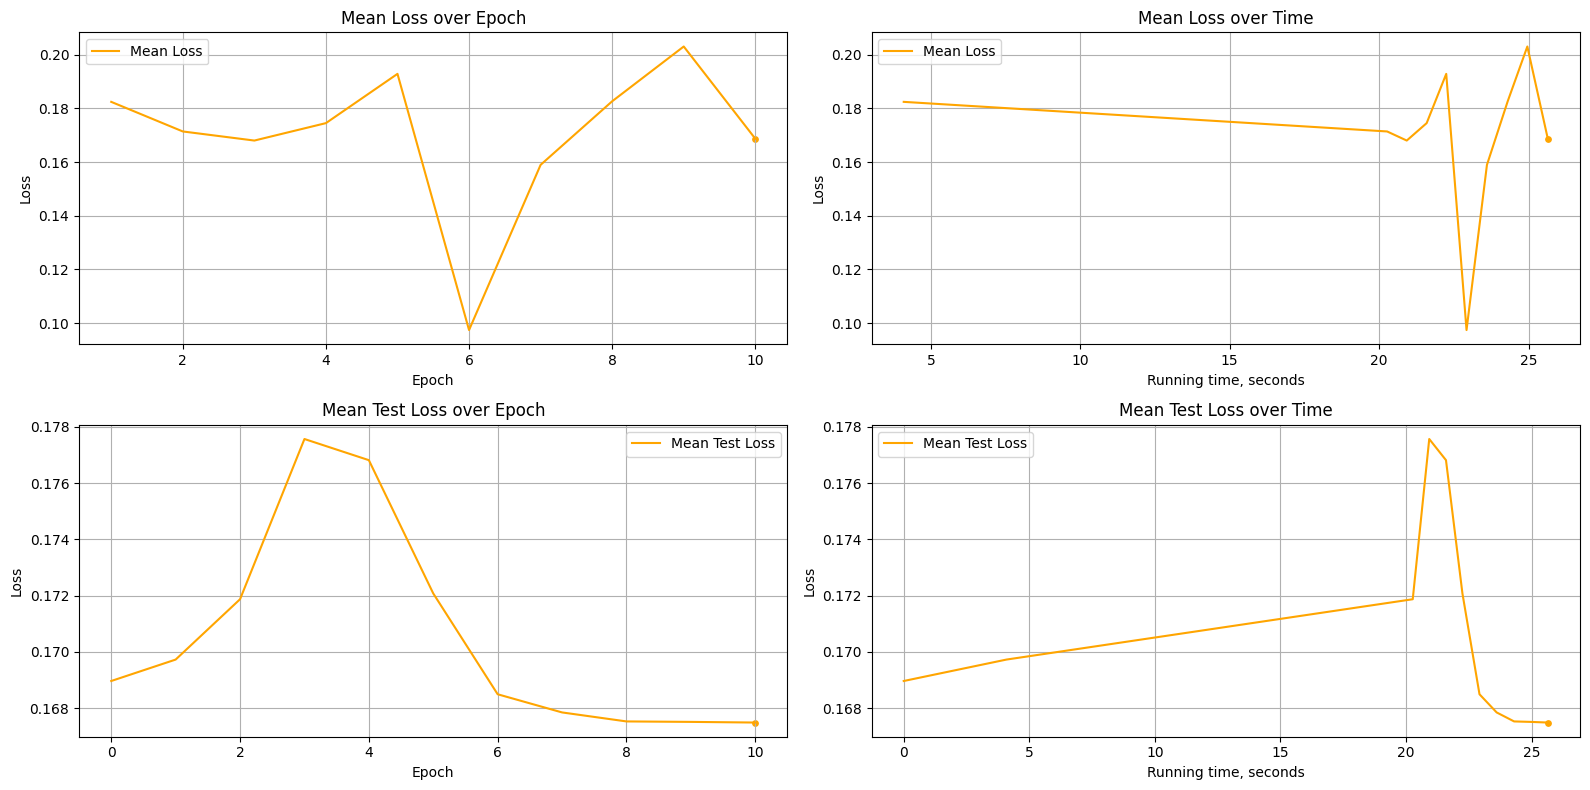

In [47]:
plots_data = {
    "Epoch": log_data["Epoch"],
    "Time": log_data["Time"],
    "Eval Epoch": log_data["Eval Epoch"],
    "Eval Time": log_data["Eval Time"],
    "Mean Loss": moving_average(log_data["Mean Loss"]),
    "Mean Test Loss": log_data["Mean Test Loss"],
    "Minimizing constant": minimizing_constant,
}

plots = LOGGER.log_plots

draw_plots(
    plots_data,
    plots,
    plot_width=8,
    plot_height=4,
    row_plots=2,
)